In [6]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("miriamodeyianypeter/sentiment-analysis-amazon-product-reviews")

100%|██████████| 2.93M/2.93M [00:00<00:00, 125MB/s]

Extracting files...


In [7]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [9]:
df = pd.read_csv(path + "/Amazon-Product-Reviews - Amazon Product Review (1).csv")

In [10]:
df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30841,US,44834233,R366C7ARIWLN7R,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,3720,3875,N,Y,A great upgrade for me from an older Kindle Fire!,[[VIDEOID:moP3B6GS5RL8LY]]I purchased the orig...,2014-10-03,1
30842,US,13376158,R35PL0AOCUXLU9,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,2716,2849,N,Y,Great Value for $139,I'm writing this review with the benefit of be...,2014-10-03,1
30843,US,40485963,R18ZJVY86AUFII,B00KC6XV58,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,1525,1629,N,Y,Even grandma has it figured out!,"I purchased this Kindle for my grandma, becaus...",2014-10-03,1
30844,US,33485035,R36QVLQXMCZRSJ,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,143,163,N,Y,The Honda Accord of Tablets,I bought my tablet Fire HD 7 at Best Buy on th...,2014-10-03,1


In [12]:
df.shape

(30846, 16)

In [13]:
df.isnull().sum()

,0
marketplace,0
customer_id,0
review_id,0
product_id,0
product_parent,0
product_title,0
product_category,0
star_rating,0
helpful_votes,0
total_votes,0


In [11]:
df.dropna(inplace=True)

In [17]:
df.isnull().sum()

,0
marketplace,0
customer_id,0
review_id,0
product_id,0
product_parent,0
product_title,0
product_category,0
star_rating,0
helpful_votes,0
total_votes,0


In [24]:
df.dtypes

,0
marketplace,object
customer_id,int64
review_id,object
product_id,object
product_parent,int64
product_title,object
product_category,object
star_rating,int64
helpful_votes,int64
total_votes,int64


In [12]:
# Combine review_headline and review_body
df['full_review'] = df['review_headline'].astype(str) + " " + df['review_body'].astype(str)

In [14]:
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'<br\s*/?>', ' ', text)  # Remove HTML tags
    text = re.sub(r'\[.*?\]', '', text)  # Remove brackets
    text = re.sub(r'[^a-z\s]', '', text)  # Remove non-letters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

In [15]:
df['clean_review'] = df['full_review'].apply(clean_text)

In [16]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
# Tokenize and remove stopwords
df['clean_review'] = df['clean_review'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [19]:
X = df['clean_review']
y = df['sentiment']

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [122]:
# Create a pipeline with TF-IDF and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=1000))
])

In [123]:
# Train the model
model = pipeline.fit(X_train, y_train)

In [107]:
pipeline.predict(X_train)

array([1, 1, 1, ..., 1, 1, 1])

In [124]:
# Predict and evaluate
y_pred = pipeline.predict(X_test)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9312581063553826

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.72      0.78       775
           1       0.95      0.97      0.96      3851

    accuracy                           0.93      4626
   macro avg       0.90      0.85      0.87      4626
weighted avg       0.93      0.93      0.93      4626


Confusion Matrix:
 [[ 558  217]
 [ 101 3750]]


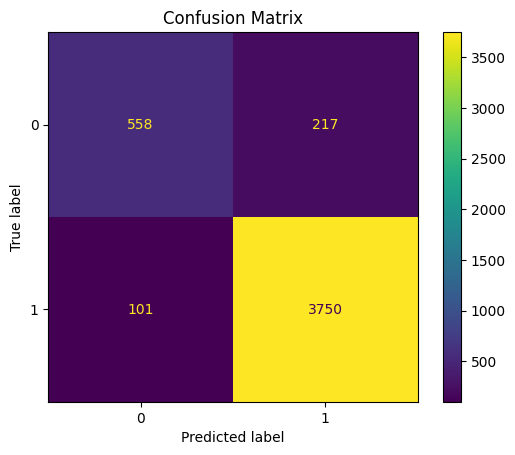

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion Matrix Plot
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()